# To Analyze how travelers expressed their feelings on Twitter.

# Import modules and create spark session

In [1]:
# create spark context 
from pyspark import SparkContext
sc = SparkContext(master = "local")
                  
# initialize the Spark Session
from pyspark.sql import SparkSession

#create Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sentiment Analysis in pySpark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Reading Data file into Spark DataFrame

In [2]:
# --- reading data via Spark
df = spark.read.csv("./*.csv", inferSchema = True, header = True, sep=",")
df.printSchema()


root
 |-- tweet_id: string (nullable = true)
 |-- airline_sentiment: string (nullable = true)
 |-- airline_sentiment_confidence: string (nullable = true)
 |-- negativereason: string (nullable = true)
 |-- negativereason_confidence: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- airline_sentiment_gold: string (nullable = true)
 |-- name: string (nullable = true)
 |-- negativereason_gold: string (nullable = true)
 |-- retweet_count: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- tweet_coord: string (nullable = true)
 |-- tweet_created: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- user_timezone: string (nullable = true)



In [3]:
df = df.na.drop(subset=["airline_sentiment","airline","text"])

In [4]:
from pyspark.sql.functions import col, expr, when
df = df.withColumn('airline_sentiment', when(col('airline_sentiment')=='positive', 2)
                .when(col('airline_sentiment')=='negative',0)
              .otherwise(1))


## Select the related data

In [5]:
# --- select only "text" and "airline_sentiment" column, 
# --- and cast "airline_sentiment" column data into integer
data = df.select(col("airline_sentiment").cast("Int").alias("label"),"text")
data.show(truncate = False,n=5)

+-----+----------------------------------------------------------------------------------------------------------------------------------+
|label|text                                                                                                                              |
+-----+----------------------------------------------------------------------------------------------------------------------------------+
|1    |@VirginAmerica What @dhepburn said.                                                                                               |
|2    |@VirginAmerica plus you've added commercials to the experience... tacky.                                                          |
|1    |@VirginAmerica I didn't today... Must mean I need to take another trip!                                                           |
|0    |"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"|
|0    |@VirginAmerica and i

In [6]:
data.printSchema()

root
 |-- label: integer (nullable = false)
 |-- text: string (nullable = true)



### Divided the data into training and testing

In [7]:
# #divide data, 70% for training, 30% for testing
# dividedData = data.randomSplit([0.7, 0.3]) 
# trainingData = dividedData[0] #index 0 = data training
# testingData = dividedData[1] #index 1 = data testing

In [74]:
# trainingData.write.csv('train.csv')
# testingData.write.csv('test.csv')

# Importing MLlib: RDD-based API and all required lib.

In [139]:
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.feature import ChiSqSelector

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import os, tempfile
import csv
import string
import random

## Data Cleaning

In [140]:
# --- function to remove stop words
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

# --- function to handle numbers, single characters URL's and @Username
# --- Cleaning data

def clean(filename):
    text=open(filename, encoding='ISO-8859-1')
    file_reader = csv.reader(text)
    clean_final=[]
    c=0
    stop=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
          'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 
          'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 
          'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 
          'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 
          'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
          'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',
          'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
          'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
          'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should',
          'now']
    shuffle=[]
    tweet_list=[]
    for row in file_reader:
        temp_t=row[1]
        ts=temp_t.split(" ")
        for w in range(1,len(ts)):
            ts[w]=ts[w].lower()
            if (ts[w]!='' and ts[w][0]=='@'):
                ts[w]='AT_USER'
            if (ts[w]!='' and len(ts[w])>4  and ts[w][0]=='w' and ts[w][1]=='w' and ts[w][2]=='w' and ts[w][3]=='.'):
                ts[w]='URL'
            if (ts[w]!='' and len(ts[w])>7  and ts[w][0]=='h' and ts[w][1]=='t' and ts[w][2]=='t' and ts[w][3]=='p' and
                ts[w][4]==':' and ts[w][5]=='/' and ts[w][6]=='/'):
                ts[w]='URL'
            if (ts[w]!='' and len(ts[w])>8  and ts[w][0]=='h' and ts[w][1]=='t' and ts[w][2]=='t' and ts[w][3]=='p' and
                ts[w][4]=='s' and ts[w][5]==':' and ts[w][6]=='/' and ts[w][7]=='/'):
                ts[w]='URL'
            for i in range(0,len(ts[w])):
                flag=0
                if len(ts[w])>i+2 and ts[w][i]==ts[w][i+1] and ts[w][i]==ts[w][i+2]:
                    for j in range(i+2,len(ts[w])):
                        if ts[w][i]==ts[w][j]:
                            flag=1
                            if len(ts[w])>j+1 and ts[w][i]!=ts[w][j+1]:
                                break
                        if j==(len(ts[w]))-1 and ts[w][i]==ts[w][j]:
                            flag=1
                            break
                    if flag==1:
                        ts[w]=ts[w].replace(ts[w][i:j+1],ts[w][i])
            if (ts[w]!='' and ts[w][0].isdigit()):
                ts[w]=''
        for i in range(0,len(stop)):
            if stop[i] in ts:
                ts = remove_values_from_list(ts, stop[i])
        cleaned_list=[word.strip(string.punctuation) for word in ts]
        while '' in cleaned_list:
            cleaned_list.remove('')
        clean_final.append(cleaned_list)
        shuffle.append([row[0],cleaned_list])
        tweet_list.append(row[1])
    return (shuffle,tweet_list)

### Processed data for training 

In [141]:
# Replace the path of train.csv in the "_____"    
train_shuffle,train_tweet_list=clean("train.csv/part-00000-0c2be565-64f3-483f-a8fd-2d14ac0f34df-c000.csv")

### Processed data for testing 

In [142]:
#test on test.csv(reading test.csv and classifying)
# Replace the path of test.csv in the "_____"
test_shuffle,test_tweet_list=clean("test.csv/part-00000-c88a2743-382f-42bf-a7fd-45a1a534c8a0-c000.csv")

## TF-IDF functions 

In [143]:
# --- Compute TF
# --- The HashingTF that is the term frequency is computed for a feature space of 25000 and 50000
def CompTF(tshuffle_rdd):
    t_rdd=sc.parallelize([row[1] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(100000)
    tf = hashingTF.transform(t_rdd)
    return tf
# --- the HashingTF that is the term frequency is computed for a feature space of 1500 and 3000 for Decision Tree
def CompTF_withNumFeatures(tshuffle_rdd):
    t_rdd=sc.parallelize([row[1] for row in tshuffle_rdd.collect()])
    hashingTF = HashingTF(6000)
    tf = hashingTF.transform(t_rdd)
    return tf
# --- Compute IDF
# --- The IDF() computes the Inverse document frequency
def CompIDF(tf):
    tf.cache()
    idf = IDF().fit(tf)
    return idf
#Compute TFIDF
def CompTFIDF(tf,idf):
    tfidf = idf.transform(tf)
    return tfidf


In [144]:
# --- Feature Extraction
# --- Converts a pair of labels and features into a Labeled Point
def Convert_to_LabeledPoint(labels,features):
    training = labels.zip(features).map(lambda x: LabeledPoint(x[0], x[1]))
    return training

## Training Algorithms 

In [145]:
# --- Naive Bayes
#Training - NB
def NB_train(training):
    model = NaiveBayes.train(training)
    return model

# --- Logistic Regression
#Training - LG
def LG_train(training):
    model = LogisticRegressionWithLBFGS.train(training,numClasses=3)
    return model


# --- Decision Trees
#Training - DT
def DT_train(training):
    model = DecisionTree.trainClassifier(training, numClasses=3, categoricalFeaturesInfo={},
                                        impurity='gini', maxDepth=5, maxBins=32)
    return model

### Testing functions 

In [146]:
# --- Testing
# --- Predicts labels based on the given features
def test(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return acc

# --- Testing with pred prob
# -- Predicts labels based on the given features and also returns the set of predicts probabilities
# -- (Only for Logistic Regression)
def test_wpp(model,labels,features):
    labels_and_probs = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "probs": float(x[1])})
    return labels_and_probs
    
# --- Final Testing
# --- Predicts labels based on the given features and returns predicted labels also for the purpose of calculation
def test_final(model,labels,features):
    labels_and_preds = labels.zip(model.predict(features)).map(
                                lambda x: {"actual": float(x[0]), "predicted": float(x[1])})
    acc=100.0*((labels_and_preds.filter(lambda x:x["actual"]==x["predicted"]).count()) / (labels.count()))
    return (labels_and_preds,acc)


In [147]:
# --- True positive rate and false positive rate
def tf(labels_and_preds):
    true_pos = (labels_and_preds.filter(lambda x:x["predicted"]==1 and x["actual"]==1).count())
    true_neg = (labels_and_preds.filter(lambda x:x["predicted"]==0 and x["actual"]==0).count())
    false_pos = (labels_and_preds.filter(lambda x:x["predicted"]==1 and x["actual"]==0).count())
    false_neg = (labels_and_preds.filter(lambda x:x["predicted"]==0 and x["actual"]==1).count())

    tpr=(true_pos)/(true_pos+false_neg)
    fpr=(false_pos)/(false_pos+true_neg)
    return (tpr,fpr)

## Spliting the training data for Cross-Validation

In [148]:
random.shuffle(train_shuffle)
tshuff_rdd_train=sc.parallelize(train_shuffle)
p=tshuff_rdd_train.randomSplit(weights=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], seed=1)


## Applying Logistic Regression 

### 1. Training

In [149]:
%%time
# -- Accuracy of Training data using train.csv itself using LG
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)

print(training.first())

model_train_LG=LG_train(training)
accuracy=test(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
#accuracy_LG=test(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("\n TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using Logistic Regression is",accuracy,"%")
print ("\n")

(0.0,(100000,[3760,6843,19004,21638,24323,27300,31954,39327,49128,52364,60636,60803,61649,71532,72824,78344,83856],[4.022010164284395,5.893812341185987,5.464816735667628,4.620846665373099,4.954514607739022,6.74111020157319,1.4849177613258244,5.488347233077822,8.532869670801245,3.8789093206437215,4.381829764902599,4.421995806627934,3.3567199382274158,4.242410229652854,3.9949082345066036,1.6960734807596018,3.7085639548964826]))

 TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using Logistic Regression is 99.16313872206361 %


CPU times: user 420 ms, sys: 43.4 ms, total: 463 ms
Wall time: 14.2 s


### 2. Validation using K Fold Cross Validation

In [150]:
%%time
# KFold Logistic Regression
print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")
tot_LG_kfold=0
LG_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train=LG_train(training)
    tf_test=CompTF(test_RDD)
    tfidf_test=CompTFIDF(tf_test,idf_train)
    accuracy_LG=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for LG is",accuracy_LG,"%")
    tot_LG_kfold=tot_LG_kfold+accuracy
    LG_kfold_set.append(accuracy)
avg_LG_kfold=tot_LG_kfold/len(p)
LG_kfold_best=max(LG_kfold_set)
print ("\n")
print ("The average accuracy for LG after 10-fold cross validation is",avg_LG_kfold,"%")
print ("\n")
print ("The highest accuracy for LG after 10-fold cross validation is",LG_kfold_best,"%")
print ("\n")

10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for LG is 69.78636826042727 %
The accuracy for number 2 kth partition test for 10-fold cross validation for LG is 66.50342801175319 %
The accuracy for number 3 kth partition test for 10-fold cross validation for LG is 68.41611996251171 %
The accuracy for number 4 kth partition test for 10-fold cross validation for LG is 70.68311195445919 %
The accuracy for number 5 kth partition test for 10-fold cross validation for LG is 69.17599186164801 %
The accuracy for number 6 kth partition test for 10-fold cross validation for LG is 67.46268656716417 %
The accuracy for number 7 kth partition test for 10-fold cross validation for LG is 69.0010298661174 %
The accuracy for number 8 kth partition test for 10-fold cross validation for LG is 68.73804971319312 %
The accuracy for number 9 kth partition test for 10-fold cross validation for LG is 68.03519061583577 %
The accuracy for number

### 3. Testing the model on the test dataset.

In [151]:
%%time
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)

labels_and_preds_LG,accu_LG = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for LG on testing data is",accu_LG,"%")
print ("\n")


TEST ACCURACY:-

The accuracy of prediction for LG on testing data is 69.37541974479517 %


CPU times: user 174 ms, sys: 37.6 ms, total: 211 ms
Wall time: 1.37 s


### 4. Ploting different accuracies 

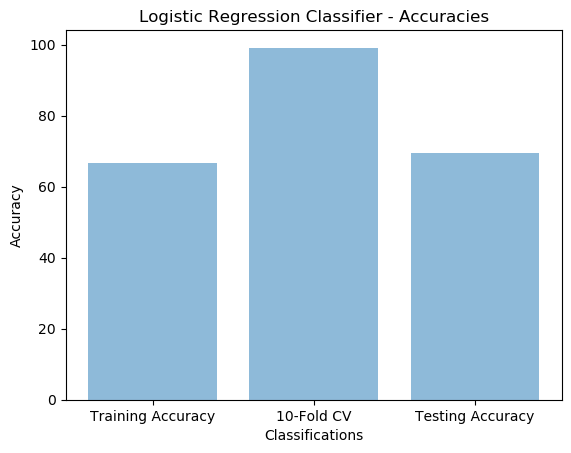

In [152]:
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_LG,avg_LG_kfold,accu_LG]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Classifier - Accuracies') 
plt.show()

### 5. Model Summary - Confussion metrics

In [153]:
metrics = MulticlassMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
# Model summary 
print("\nSummary Stats_LG\n")
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_LG = %s" % (label, metrics.precision(label)))
    print("Class %s recall_LG = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))
# Model Weighted Stats 
print("\n\nAvg/Weighted recall_LG = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_LG = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_LG = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_LG=")
print(cm)
print("\n\n")


Summary Stats_LG

Class 0 precision_LG = 0.8026599568655644
Class 0 recall_LG = 0.8017953321364453
Class 0 F1 Measure_NB = 0.8022274115322436
Class 1 precision_LG = 0.4648033126293996
Class 1 recall_LG = 0.47816826411075614
Class 1 F1 Measure_NB = 0.4713910761154856
Class 2 precision_LG = 0.5799721835883171
Class 2 recall_LG = 0.5612382234185733
Class 2 F1 Measure_NB = 0.5704514363885089


Avg/Weighted recall_LG = 0.6937541974479515
Avg/Weighted precision_LG = 0.6945998707937593
Avg/Weighted F(1) Score_LG = 0.6941314033638687

Confusion matrix_LG=
[[2233.  376.  176.]
 [ 364.  449.  126.]
 [ 185.  141.  417.]]





### 6. ROC Curve and AUC

Area under ROC_Logistic_Regression = 0.74840789689969


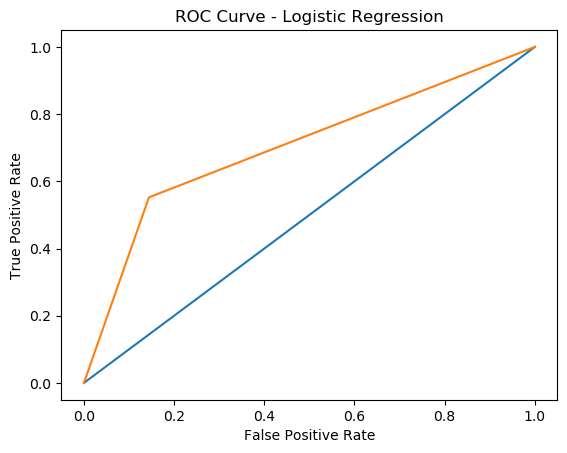

In [154]:
model_train_LG.setThreshold(0.25)
labels_and_preds_LG2,accu_LG2 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.75)
labels_and_preds_LG3,accu_LG3 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.1)
labels_and_preds_LG4,accu_LG4 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
model_train_LG.setThreshold(0.9)
labels_and_preds_LG5,accu_LG5 = test_final(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)

tpr,fpr=tf(labels_and_preds_LG) 
tpr2,fpr2=tf(labels_and_preds_LG2) 
tpr3,fpr3=tf(labels_and_preds_LG3)
tpr4,fpr4=tf(labels_and_preds_LG4) 
tpr5,fpr5=tf(labels_and_preds_LG5) 

x = [0,fpr5,fpr3,fpr,fpr2,fpr4,1]
y = [0,tpr5,tpr3,tpr,tpr2,tpr4,1]

# This is the ROC curve
x1=[0,1]
y1=[0,1]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.plot(x1,y1)
plt.plot(x,y)

metrics2 = BinaryClassificationMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
model_train_LG.clearThreshold()
labels_and_probs_LG=test_wpp(model_train_LG,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
metrics = MulticlassMetrics(labels_and_preds_LG.map(lambda x: (x["predicted"], x["actual"])))
# Area under ROC curve
print("Area under ROC_Logistic_Regression = %s" % metrics2.areaUnderROC)
plt.show()

## Applying Naive Bayes 


### 1. Training

In [155]:
%%time
#Accuracy of Training data using train.csv itself using NB
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
#Feature Extraction\
training_NB = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
model_train_NB=NB_train(training_NB)
#testing NB with training data 
accuracy_NB=test(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using NB is",accuracy_NB,"%")
print ("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using NB is 89.11095796002758 %


CPU times: user 552 ms, sys: 55.8 ms, total: 608 ms
Wall time: 4.65 s


### 2. Validation using K Fold Cross Validation

In [156]:
%%time
# KFold NB
print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")
tot_NB_kfold=0
NB_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train=NB_train(training)
    tf_test=CompTF(test_RDD)
    tfidf_test=CompTFIDF(tf_test,idf_train)
    accuracy=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for NB is",accuracy,"%")
    NB_kfold_set.append(accuracy)
    tot_NB_kfold=tot_NB_kfold+accuracy
avg_NB_kfold=tot_NB_kfold/len(p)
NB_kfold_best=max(NB_kfold_set)
print ("\n")
print ("The average accuracy for NB after 10-fold cross validation is",avg_NB_kfold,"%")
print ("\n")
print ("The highest accuracy for NB after 10-fold cross validation is",NB_kfold_best,"%")
print ("\n")

10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for NB is 71.00712105798576 %
The accuracy for number 2 kth partition test for 10-fold cross validation for NB is 72.47796278158668 %
The accuracy for number 3 kth partition test for 10-fold cross validation for NB is 72.5398313027179 %
The accuracy for number 4 kth partition test for 10-fold cross validation for NB is 75.71157495256166 %
The accuracy for number 5 kth partition test for 10-fold cross validation for NB is 74.26246185147508 %
The accuracy for number 6 kth partition test for 10-fold cross validation for NB is 73.33333333333333 %
The accuracy for number 7 kth partition test for 10-fold cross validation for NB is 74.04737384140063 %
The accuracy for number 8 kth partition test for 10-fold cross validation for NB is 73.80497131931166 %
The accuracy for number 9 kth partition test for 10-fold cross validation for NB is 73.11827956989248 %
The accuracy for number

### 3. Testing the model on the test dataset.

In [157]:
%%time
#print (test_shuffle)
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)
labels_and_preds_NB,accu_NB = test_final(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for NB on testing data is",accu_NB,"%")


TEST ACCURACY:-

The accuracy of prediction for NB on testing data is 73.76315200358182 %
CPU times: user 130 ms, sys: 35.1 ms, total: 165 ms
Wall time: 1.22 s


### 4. Ploting different accuracies

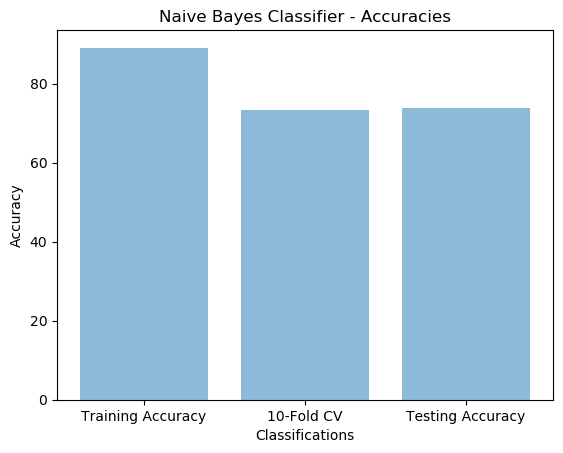

In [158]:
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_NB,avg_NB_kfold,accu_NB]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier - Accuracies')
plt.show()

### 5. Model Summary - Confussion Matrix

In [159]:
metrics = MulticlassMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_NB\n")
# Statistics by class
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_NB = %s " % (label, metrics.precision(label)))
    print("Class %s recall_NB = %s " % (label, metrics.recall(label)))
    print("Class %s F1 Measure_NB = %s \n" % (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\nAvg/Weighted recall_NB = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_NB = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_NB = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_NB=")
print(cm)
print("\n")


Summary Stats_NB

Class 0 precision_NB = 0.7626666666666667 
Class 0 recall_NB = 0.9242369838420108 
Class 0 F1 Measure_NB = 0.8357142857142857 

Class 1 precision_NB = 0.6082474226804123 
Class 1 recall_NB = 0.3769968051118211 
Class 1 F1 Measure_NB = 0.46548323471400394 

Class 2 precision_NB = 0.7196078431372549 
Class 2 recall_NB = 0.4939434724091521 
Class 2 F1 Measure_NB = 0.5857940941739824 


Avg/Weighted recall_NB = 0.7376315200358183
Avg/Weighted precision_NB = 0.7230444647446953
Avg/Weighted F(1) Score_NB = 0.7163192422390876

Confusion matrix_NB=
[[2574.  141.   70.]
 [ 512.  354.   73.]
 [ 289.   87.  367.]]




### 6. ROC Curve and AUC

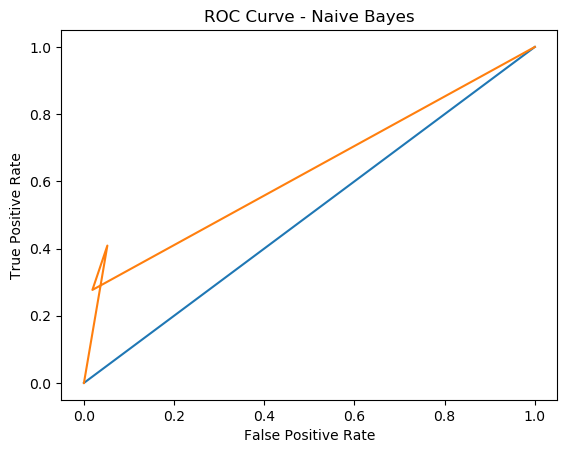

Area under ROC_NB = 0.7273361199051313


In [160]:
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF(tshuff_rdd_test)
tf_train=CompTF(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)
labels_and_preds_NB2,accu_NB2 = test_final(model_train_NB,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tf_test)
tpr,fpr=tf(labels_and_preds_NB)
tpr2,fpr2=tf(labels_and_preds_NB2)
x = [0,fpr,fpr2,1]
y = [0,tpr,tpr2,1]
# This is the ROC curve
x1=[0,1]
y1=[0,1]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.plot(x1,y1)
plt.plot(x,y)
plt.show()
metrics2 = BinaryClassificationMetrics(labels_and_preds_NB.map(lambda x: (x["predicted"], x["actual"])))
# Area under ROC curve
print("Area under ROC_NB = %s" % metrics2.areaUnderROC)

## Applying Decision Tree

### 1. Training

In [161]:
%%time
#Accuracy of Training data using train.csv itself using DT
#print (test_shuffle)
tf_train=CompTF_withNumFeatures(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_train=CompTFIDF(tf_train,idf_train)
## features extractions
training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
model_train_DT=DT_train(training)
accuracy_DT=test(model_train_DT,sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tfidf_train)
print ("TRAINING ACCURACY:-\n")
print("The accuracy for the training dataset tested on the training data itself using DT is",accuracy_DT,"%")
print("\n")

TRAINING ACCURACY:-

The accuracy for the training dataset tested on the training data itself using DT is 69.39056808112632 %


CPU times: user 235 ms, sys: 39.6 ms, total: 274 ms
Wall time: 10.8 s


### 2. Validation using K Fold Cross Validation

In [162]:
%%time
# KFold DT
print ("10-FOLD CV ACCURACIES FOR ALL ITERATIONS\n")
tot_DT_kfold=0
DT_kfold_set=[]
for i in range(0,len(p)):
    test_RDD=p[i]
    train_tempRDD=sc.emptyRDD()
    for j in range(0,len(p)):
        if i!=j:
            train_tempRDD=train_tempRDD.union(p[j])
    tf_train=CompTF_withNumFeatures(train_tempRDD)
    idf_train=CompIDF(tf_train)
    tfidf_train=CompTFIDF(tf_train,idf_train)
    training = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in train_tempRDD.collect()]),tfidf_train)
    model_train = DT_train(training)
    tf_test = CompTF_withNumFeatures(test_RDD)
    tfidf_test = CompTFIDF(tf_test,idf_train)
    accuracy=test(model_train,sc.parallelize([row[0] for row in test_RDD.collect()]),tfidf_test)
    print ("The accuracy for number",i+1,"kth partition test for 10-fold cross validation for DT is",accuracy,"%")
    tot_DT_kfold=tot_DT_kfold+accuracy
    DT_kfold_set.append(accuracy)
avg_DT_kfold=tot_DT_kfold/len(p)
DT_kfold_best=max(DT_kfold_set)
print("\n")
print ("The average accuracy for DT after 10-fold cross validation is",avg_DT_kfold,"%")
print("\n")
print ("The highest accuracy for DT after 10-fold cross validation is",DT_kfold_best,"%")
print("\n")

10-FOLD CV ACCURACIES FOR ALL ITERATIONS

The accuracy for number 1 kth partition test for 10-fold cross validation for DT is 68.05696846388607 %
The accuracy for number 2 kth partition test for 10-fold cross validation for DT is 67.48285994123408 %
The accuracy for number 3 kth partition test for 10-fold cross validation for DT is 66.9165885660731 %
The accuracy for number 4 kth partition test for 10-fold cross validation for DT is 71.34724857685009 %
The accuracy for number 5 kth partition test for 10-fold cross validation for DT is 70.39674465920652 %
The accuracy for number 6 kth partition test for 10-fold cross validation for DT is 69.75124378109453 %
The accuracy for number 7 kth partition test for 10-fold cross validation for DT is 68.79505664263645 %
The accuracy for number 8 kth partition test for 10-fold cross validation for DT is 68.06883365200764 %
The accuracy for number 9 kth partition test for 10-fold cross validation for DT is 69.50146627565982 %
The accuracy for number

### 3. Testing the model on the test dataset.

In [163]:
%%time
tshuff_rdd_test=sc.parallelize(test_shuffle)
tf_test=CompTF_withNumFeatures(tshuff_rdd_test)
tf_train=CompTF_withNumFeatures(tshuff_rdd_train)
idf_train=CompIDF(tf_train)
tfidf_test=CompTFIDF(tf_test,idf_train)
labels_and_preds_DT,accu_DT = test_final(model_train_DT,sc.parallelize([row[0] for row in tshuff_rdd_test.collect()]),tfidf_test)
print ("\nTEST ACCURACY:-\n")
print("The accuracy of prediction for DT on testing data is",accu_DT,"%")
print("\n")


TEST ACCURACY:-

The accuracy of prediction for DT on testing data is 67.76359973136333 %


CPU times: user 136 ms, sys: 22.3 ms, total: 159 ms
Wall time: 1.75 s


### 4. Ploting different accuracies


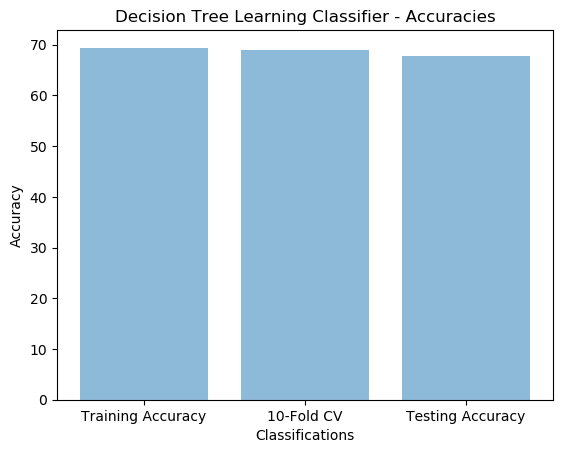

In [164]:
objects = ('Training Accuracy', '10-Fold CV', 'Testing Accuracy')
y_pos = np.arange(len(objects))
performance = [accuracy_DT,avg_DT_kfold,accu_DT]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Classifications')
plt.ylabel('Accuracy')
plt.title('Decision Tree Learning Classifier - Accuracies') 
plt.show()


### 5. Model Summary - Confussion Matrix


In [165]:
metrics = MulticlassMetrics(labels_and_preds_DT.map(lambda x: (x["predicted"], x["actual"])))
# Overall statistics
print("\nSummary Stats_D\n")
# Statistics by class
labels = (sc.parallelize([row[0] for row in tshuff_rdd_test.collect()])).distinct().collect()
for label in sorted(labels):
    print("Class %s precision_DT = %s" % (label, metrics.precision(label)))
    print("Class %s recall_DT = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure_DT = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

# Weighted stats
print("\n\nAvg/Weighted recall_DT = %s" % metrics.weightedRecall)
print("Avg/Weighted precision_DT = %s" % metrics.weightedPrecision)
print("Avg/Weighted F(1) Score_DT = %s" % metrics.weightedFMeasure())

cm=metrics.confusionMatrix().toArray()
print("\nConfusion matrix_DT=")
print(cm)


Summary Stats_D

Class 0 precision_DT = 0.6942675159235668
Class 0 recall_DT = 0.9393177737881508
Class 0 F1 Measure_DT = 0.7984129406378757
Class 1 precision_DT = 0.4834710743801653
Class 1 recall_DT = 0.12460063897763578
Class 1 F1 Measure_DT = 0.1981371718882303
Class 2 precision_DT = 0.6433260393873085
Class 2 recall_DT = 0.39569313593539707
Class 2 F1 Measure_DT = 0.49


Avg/Weighted recall_DT = 0.6776359973136333
Avg/Weighted precision_DT = 0.6414832366140316
Avg/Weighted F(1) Score_DT = 0.6209314627444666

Confusion matrix_DT=
[[2616.   80.   89.]
 [ 748.  117.   74.]
 [ 404.   45.  294.]]


## Which is the Best Classifier?
The classifier with a better cross valiation score is the best.



In [166]:
maxi=max(float(avg_NB_kfold),float(avg_LG_kfold),float(avg_DT_kfold))
maxi_high=max(float(DT_kfold_best),float(LG_kfold_best),float(NB_kfold_best))
print ("Most accurate based on highest 10-fold CV accuracy:-\n")
if maxi_high==NB_kfold_best:
     print ("Naive Bayes is the most accurate Classifier\n")
elif maxi_high==LG_kfold_best:
    print ("Logistic Regression is the most accurate Classifier\n")
elif maxi_high==DT_kfold_best:
    print ("Decision Trees  is the most accurate Classifier\n")

Most accurate based on highest 10-fold CV accuracy:-

Logistic Regression is the most accurate Classifier



## Fetching some of the Tweets after selecting the best classifer!
I outputed the prediction probabilitioes and the corresponding tweet for Correctly and Incorrectly predicted label for tweets

In [167]:
 
print ("Most accurate based on average 10-fold CV accuracy:-\n")

if maxi==avg_NB_kfold:
    print ("NB is the most accurate Classifier")
    lpr= labels_and_preds_NB.map(lambda x:[x["predicted"],x["actual"]])
    lpr_list=[]
    for i in lpr.collect():
        lpr_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction labels(NB):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorrectly along with their prediction labels(NB):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("Correctly classified tweets (5)(NB):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    print("******************************************************")
    print ("Incorrectly classified tweets (5)(NB):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
elif maxi==avg_LG_kfold:
    print ("LG is the most accurate Classifier")
    lp=labels_and_probs_LG.map(lambda x:[x["probs"],x["actual"]])
    lp_list=[]
    for i in lp.collect():
        lp_list.append(i)
    pred=labels_and_preds_LG.map(lambda x:x["predicted"])
    pred_list=[]
    for i in pred.collect():
        pred_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction probabilities(LG):-\n")
    c=0
    for i in range(0,len(lp_list)):
        if lp_list[i][1]==pred_list[i]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction probability - ",lp_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorreclty along with their prediction probabilities(LG):-\n")
    c=0
    for i in range(0,len(lp_list)):
        if lp_list[i][1]!=pred_list[i]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction probability - ",lp_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    corr_tw_lg=[]
    incorr_tw_lg=[]
    for i in range(0,len(lp_list)):
        if lp_list[i][1]==pred_list[i]:
            corr_tw_lg.append([lp_list[i][0],test_tweet_list[i]])
    for i in range(0,len(lp_list)):
        if lp_list[i][1]!=pred_list[i]:
            incorr_tw_lg.append([lp_list[i][0],test_tweet_list[i]])
    
    corr_tw_lg=sorted(corr_tw_lg,key=lambda l:l[0], reverse=True)
    incorr_tw_lg=sorted(incorr_tw_lg,key=lambda l:l[0], reverse=True)
    
    print("******************************************************")
    c=0
    print("Correctly classified tweets sorted by probabilities are (LG):-\n")
    for i in range(0,len(corr_tw_lg)):
        print(i+1,") tweet - ",corr_tw_lg[i][1])
        print("prediction probability - ",corr_tw_lg[i][0])
        print("\n")
        c=c+1
        if c==5:
            break
    print("******************************************************")
    c=0
    print("Incorrectly classified tweets sorted by probabilities are (LG):-")
    for i in range(0,len(corr_tw_lg)):
        print(i+1,") tweet - ",incorr_tw_lg[i][1])
        print ("prediction probability - ",incorr_tw_lg[i][0])
        print("\n")
        c=c+1
        if c==5:
            break
    
elif maxi==avg_DT_kfold:
    print ("DT is the most accurate Classifier")
    lpr= labels_and_preds_DT.map(lambda x:[x["predicted"],x["actual"]])
    lpr_list=[]
    for i in lpr.collect():
        lpr_list.append(i)
    print("******************************************************")
    print ("some test tweets that are classified correctly along with their prediction labels(DT):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("some test tweets that are classified incorrectly along with their prediction labels(DT):-\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==6:
                break
    print("******************************************************")
    print ("Correctly classified tweets (5)(DT):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]==lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    print("******************************************************")
    print ("Incorrectly classified tweets (5)(DT):-\n\n")
    c=0
    for i in range(0,len(lpr_list)):
        if lpr_list[i][1]!=lpr_list[i][0]:
            print(i+1,") tweet - ",test_tweet_list[i])
            print("prediction label - ",lpr_list[i][0])
            print("\n")
            c=c+1
            if c==5:
                break
    
else:
    print ("Error Occured")

Most accurate based on average 10-fold CV accuracy:-

LG is the most accurate Classifier
******************************************************
some test tweets that are classified correctly along with their prediction probabilities(LG):-

1 ) tweet -  \@AmericanAir  so far all I am getting is \"\"maybe your bag will come today. We don't know.\"\" Website says \"\"status unknown\"\"- can you help?\""
prediction probability -  0.0


2 ) tweet -  \@AmericanAir  upon entering plane to 2 @USAirways stewardesses: \"\"can I have some water?\"\" \"\"no we don't do that. please take your seat\"\"\""
prediction probability -  0.0


3 ) tweet -  \@AmericanAir \"\"We'll drop off your luggage 24 hours after your flight\"\" is ridiculous.\""
prediction probability -  0.0


4 ) tweet -  \@AmericanAir AA1675 flight out of Jamaica was Cancelled Flightled yesterday due to \"\"weather\"\""
prediction probability -  0.0


5 ) tweet -  \@AmericanAir Define \"\"sincerely\"\". Your actions do not reflect wh

## What are some of the most informative features?
- I made use of the ChiSqSelector which is an inbuilt function of mllib, but this function only returns hashed values

In [168]:
training_chi = Convert_to_LabeledPoint(sc.parallelize([row[0] for row in tshuff_rdd_train.collect()]),tf_train)
selector = ChiSqSelector(20)
transformer = selector.fit(training_chi)
filteredData = (sc.parallelize([row[0] for row in tshuff_rdd_train.collect()])).zip(transformer.transform(tf_train)).map(lambda x: LabeledPoint(x[0], x[1]))
print ("\n\n20 Most Informative Features for the label 0.0 Negative (According to ChiSqSelector)\n")
c=0
for i in filteredData.collect():
    if i.label==0.0:
        print (i.features)
        c=c+1
    if c==20:
        break                  
print ("\n20 Most Informative Features for the label Neutral 1.0 (According to ChiSqSelector)\n")
c=0
for i in filteredData.collect():
    if i.label==1.0:
        print (i.features)
        c=c+1
    if c==20:
        break
print ("\n20 Most Informative Features for the label Positive 2.0 (According to ChiSqSelector)\n")
c=0
for i in filteredData.collect():
    if i.label==2.0:
        print (i.features)
        c=c+1
    if c==20:
        break  



20 Most Informative Features for the label 0.0 Negative (According to ChiSqSelector)

(20,[12],[1.0])
(20,[],[])
(20,[],[])
(20,[],[])
(20,[],[])
(20,[9],[1.0])
(20,[],[])
(20,[],[])
(20,[3],[1.0])
(20,[9,12],[1.0,1.0])
(20,[7,12,13],[1.0,1.0,1.0])
(20,[6,12],[1.0,1.0])
(20,[],[])
(20,[18],[1.0])
(20,[],[])
(20,[3],[1.0])
(20,[],[])
(20,[0,2],[1.0,1.0])
(20,[5],[1.0])
(20,[6,12],[1.0,1.0])

20 Most Informative Features for the label Neutral 1.0 (According to ChiSqSelector)

(20,[5,12],[1.0,1.0])
(20,[],[])
(20,[9],[1.0])
(20,[9],[1.0])
(20,[5],[1.0])
(20,[8,15],[1.0,1.0])
(20,[5],[1.0])
(20,[],[])
(20,[5,8],[1.0,1.0])
(20,[],[])
(20,[5,17],[1.0,1.0])
(20,[5,8],[1.0,1.0])
(20,[],[])
(20,[0,8],[1.0,1.0])
(20,[],[])
(20,[],[])
(20,[0,12],[1.0,1.0])
(20,[5],[1.0])
(20,[12],[1.0])
(20,[8],[1.0])

20 Most Informative Features for the label Positive 2.0 (According to ChiSqSelector)

(20,[9],[1.0])
(20,[5],[1.0])
(20,[5],[1.0])
(20,[9,12],[1.0,1.0])
(20,[6,9],[1.0,1.0])
(20,[4,5],[1.0,1.0])


In [169]:
print ("\n\nTop 30 most informative features(On the labels ie. 0, 1 and 2):-\n")
temp={}
c=0
for i in range(0,len(train_shuffle)):
    for j in range(0,len(train_shuffle[i][1])):
        if train_shuffle[i][1][j] in temp:
            if train_shuffle[i][0]=='1'or '2' or '0':
                temp[train_shuffle[i][1][j]][0]=temp[train_shuffle[i][1][j]][0]+1
                temp[train_shuffle[i][1][j]][1]=temp[train_shuffle[i][1][j]][1]+1
        else:
            if train_shuffle[i][0]=='1': 
                temp[train_shuffle[i][1][j]]=[1,1,0]
            elif train_shuffle[i][0]=='0':
                temp[train_shuffle[i][1][j]]=[1,0,1]
            elif train_shuffle[i][0]=='2':
                temp[train_shuffle[i][1][j]]=[0,0,1]
temp2=[]
for k in temp:
    temp2.append([k,((0.33*temp[k][0])+(0.33*temp[k][1])+(0.33*temp[k][2]))])
temp2=sorted(temp2,key=lambda l:l[1], reverse=True)
c=0
print ("-------------------------")
for i in range(0,len(temp2)):
    print (i+1,") ",temp2[i][0])
    c=c+1
    if c==30:
        break
print ("-------------------------")



Top 30 most informative features(On the labels ie. 0, 1 and 2):-

-------------------------
1 )  united
2 )  flight
3 )  USAirways
4 )  AmericanAir
5 )  SouthwestAir
6 )  AT_USER
7 )  JetBlue
8 )  get
9 )  URL
10 )  cancelled
11 )  thanks
12 )  service
13 )  help
14 )  customer
15 )  time
16 )  i'm
17 )  hours
18 )  amp
19 )  plane
20 )  hold
21 )  us
22 )  flights
23 )  thank
24 )  please
25 )  delayed
26 )  one
27 )  gate
28 )  still
29 )  would
30 )  need
-------------------------


## How scalable is my project?

#### Machine Learning library (MLlib)
- This is formed by common learning algorithms and statistic utilities. Among its main functionalities includes: classification, regression, clustering, collaborative filtering, optimization, and dimensionality reduction. 

- This library has been especially designed to simplify ML pipelines in large-scale environments. In the latest versions of Spark, the MLlib library has been divided into two packages, MLlib, build on top of RDDs, and ML, build on top of DataFrames for constructing pipelines.

- The Project is based on distributed data structures called Resilient Distributed Datasets (RDDs).
    - Operations on RDDs automatically place tasks into partitions, maintaining the locality of persisted data. 
    - Beyond this, RDDs are an immutable and versatile tool that let programmers persist intermediate results into memory or disk for re-usability purposes, and customize the partitioning to optimize data placement. 
    - RDDs are also fault-tolerant by nature. 

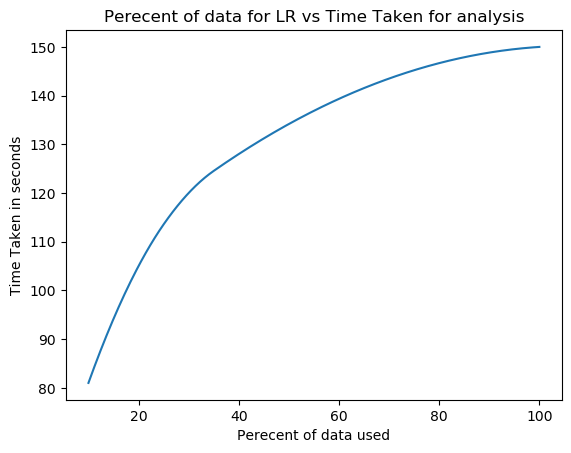

In [170]:
# importing the required module 
import matplotlib.pyplot as plt 
from scipy.interpolate import make_interp_spline, BSpline

T = np.array([10, 20, 30, 40,100])
power = np.array([81,105,120,128,150])

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(T.min(), T.max(), 300) 

spl = make_interp_spline(T, power, k=2)  # type: BSpline
power_smooth = spl(xnew)

#plt.plot(T,power)
plt.plot(xnew, power_smooth)
# naming the x axis 
plt.xlabel('Perecent of data used') 
# naming the y axis 
plt.ylabel('Time Taken in seconds') 
  
# giving a title to my graph 
plt.title('Perecent of data for LR vs Time Taken for analysis') 
  
# function to show the plot 
plt.show()